# HM1: Logistic Regression.

### Name: [Abhishek Panda]


#### For this assignment, you will build 6 models. You need to train Logistic Regression/Regularized Logistic Regression each with Batch Gradient Descent, Stochastic Gradient Descent and Mini Batch Gradient Descent. Also you should plot their objective values versus epochs and compare their training and testing accuracies. You will need to tune the parameters a little bit to obtain reasonable results.

#### You do not have to follow the following procedure. You may implement your own functions and methods, but you need to show your results and plots.

In [1]:
# Load Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1. Data processing

- Download the Breast Cancer dataset from canvas or from https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)
- Load the data.
- Preprocess the data.

## 1.1. Load the data

In [2]:
db = pd.read_csv("data.csv")
db.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## 1.2 Examine and clean data

In [3]:
# Some columns may not be useful for the model (For example, the first column contains ID number which may be irrelavant). 
# You need to get rid of the ID number feature.
# Also you should transform target labels in the second column from 'B' and 'M' to 1 and -1.
db["diagnosis"].replace({'B': 1, 'M': -1}, inplace=True)
X = db.iloc[:,2:32]
y = db.iloc[:,1]

## 1.3. Partition to training and testing sets

In [4]:
# You can partition using 80% training data and 20% testing data. It is a commonly used ratio in machinel learning.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

## 1.4. Feature scaling

Use the standardization to trainsform both training and test features

In [5]:
# calculate mu and sig using the training set
d = x_train.shape[1]
mu = np.mean(x_train, axis=0).reshape(1, d)
sig = np.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(np.mean(x_test, axis=0))

print('test std = ')
print(np.std(x_test, axis=0))

test mean = 
[ 0.01364642  0.12253495  0.01783049  0.00720095  0.22114869  0.0687223
 -0.00621403  0.08392489  0.01148491  0.02830083  0.0556954   0.13066331
  0.01883127  0.02811459  0.08481514 -0.04224216 -0.14454819 -0.07763127
 -0.01908298 -0.04579225  0.0354004   0.1165998   0.02366887  0.03165325
  0.181063    0.04909977 -0.05741449  0.0324309  -0.03375549  0.02182766]
test std = 
[0.98431415 1.03563584 0.99623795 0.95775661 1.03183046 1.03137836
 1.01678692 1.09237149 0.98768874 0.89252753 0.89195651 1.08292906
 0.87565977 0.79961715 0.90555496 0.79548557 0.62868537 0.89587391
 1.05721043 0.71238788 1.02318965 1.06105881 1.03449332 1.01541818
 0.93182513 1.07284177 0.98118292 1.0313241  0.89460198 1.05915061]


# 2.  Logistic Regression Model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

When $\lambda = 0$, the model is a regular logistric regression and when $\lambda > 0$, it essentially becomes a regularized logistric regression.

In [6]:
# Calculate the objective function value, or loss
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     objective function value, or loss (scalar)
def objective(w, x, y, lam):
    a = np.mean(np.log(1+ np.exp(-(np.dot(np.multiply(y,x),w)))))
    b = (lam/2)* np.sum(np.square(w))
    obj = a + b
    return obj

# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ for regularized logistic regression is  $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [7]:
# Calculate the gradient
# Inputs:
#     w: weight: d-by-1 matrix
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: regularization parameter: scalar
# Return:
#     g: gradient: d-by-1 matrix

def gradient(w, x, y, lam):
    n , d = x.shape
    a = -np.mean(np.divide(np.multiply(y,x),(1+ np.exp((np.dot(np.multiply(y,x),w))))), axis=0).reshape(d, 1)
    b = (lam * w)
    g = a + b
    return g

In [8]:
# Gradient descent for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value

def gradient_descent(x, y, lam, learning_rate, w, max_epoch=100):
    n, d = x.shape
    objvals = np.zeros(max_epoch)
    w = np.zeros((d, 1))
    y = np.array(y).reshape(n, 1)
    for epoch in range(max_epoch):
        w -= learning_rate * gradient(w, x, y, lam)
        objval = objective(w, x, y, lam)
        objvals[epoch] = objval
    return w, objvals

Use gradient_descent function to obtain your optimal weights and a list of objective values over each epoch.

In [9]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
w_gd, objval1_gd = gradient_descent(x_train, y_train, 0, 0.1, None, 5000)

In [10]:
# Train regularized logistric regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
w_gd_r, objval1_gd_r = gradient_descent(x_train, y_train, 1E-10, 0.1, None, 5000)

## 3.2. Stochastic gradient descent (SGD)

Define new objective function $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $. 

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [11]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: weights: d-by-1 matrix
#     xi: data: 1-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def stochastic_objective_gradient(w, xi, yi, lam):
    yxw = np.dot(np.multiply(yi,xi),w)
    a = np.log(1+ np.exp(-yxw))
    b = (lam/2) * np.sum(np.square(w))
    obj = a + b
    c = -(np.multiply(yi,xi)) / (1+ np.exp(yxw)) 
    d = (lam * w).reshape(xi.shape[0])
    g = c + d
    return obj, g

Hints:
1. In every epoch, randomly permute the $n$ samples.
2. Each epoch has $n$ iterations. In every iteration, use 1 sample, and compute the gradient and objective using the ``stochastic_objective_gradient`` function. In the next iteration, use the next sample, and so on.

In [12]:
# SGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def sgd(x, y, lam, learning_rate, w, max_epoch=100):
    n, d = x.shape
    objvals = np.zeros(max_epoch)
    w = np.zeros((d, 1))
    y = np.array(y).reshape((n,1))
    for epoch in range(max_epoch):
        rand_num = np.random.permutation(n)
        x_rand = x[rand_num, :]
        y_rand = y[rand_num, :]
        objval = 0
        for i in range(n):
            obj, g = stochastic_objective_gradient(w, x_rand[i, :], float(y_rand[i, :]), lam)
            objval += obj
            w -= (learning_rate * g.reshape((d,1)))
        objval /= n
        objvals[epoch] = objval
    
    return w, objvals

Use sgd function to obtain your optimal weights and a list of objective values over each epoch.

In [13]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
w_sgd, objval1_sgd = sgd(x_train, y_train, 0, 0.1, None, 5000)

In [14]:
# Train regularized logistric regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
w_sgd_r, objval1_sgd_r = sgd(x_train, y_train, 1E-10, 0.1, None, 5000)

## 3.3 Mini-Batch Gradient Descent (MBGD)

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

You may need to implement a new function to calculate the new objective function and gradients.

In [15]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: weights: d-by-b matrix
#     xi: data: b-by-d matrix
#     yi: label: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i

def mb_objective_gradient(w, xi, yi, lam):
    n , d = xi.shape
    yx = np.multiply(yi, xi)
    yxw = np.dot(yx,w)
    a = np.mean(np.log(1+ np.exp(-yxw)))
    b = (lam/2)* np.sum(np.square(w))
    obj = a + b
    c = np.mean(np.divide(-yx,(1+ np.exp(yxw))), axis=0).reshape(d,1)
    d = (lam * w)
    g = c + d
    return obj, g

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.

In [16]:
# MBGD for solving logistic regression
# You will need to do iterative process (loops) to obtain optimal weights in this function

# Inputs:
#     x: data: n-by-d matrix
#     y: label: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     learning_rate: scalar
#     w: weights: d-by-1 matrix, initialization of w
#     max_epoch: integer, the maximal epochs
# Return:
#     w: weights: d-by-1 matrix, the solution
#     objvals: a record of each epoch's objective value
#     Record one objective value per epoch (not per iteration)

def mbgd(x, y, lam, learning_rate, w, max_epoch=100):
    n, d = x.shape
    bs = 30     #batch size
    objvals = np.zeros(max_epoch)
    w = np.zeros((d, 1))
    y = np.array(y).reshape((n,1))
    for epoch in range(max_epoch):
        rand_num = np.random.permutation(n)
        x_rand = x[rand_num, :]
        y_rand = y[rand_num, :]
        objval = 0
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            x_batch = x_rand[start_i:end_i]
            y_batch = y_rand[start_i:end_i]
            obj, g = mb_objective_gradient(w, x_batch, y_batch, lam)
            objval += obj
            w -= learning_rate * g

        objval /= bs
        objvals[epoch] = objval
    
    return w, objvals

Use mbgd function to obtain your optimal weights and a list of objective values over each epoch.

In [17]:
# Train logistic regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
w_mbgd, objval1_mbgd = mbgd(x_train, y_train, 0, 0.1, None, 5000)

In [18]:
# Train regularized logistric regression
# You should get the optimal weights and a list of objective values by using gradient_descent function.
w_mbgd_r, objval1_mbgd_r = mbgd(x_train, y_train, 1E-10, 0.1, None, 5000)

# 4. Compare GD, SGD, MBGD

### Plot objective function values against epochs.

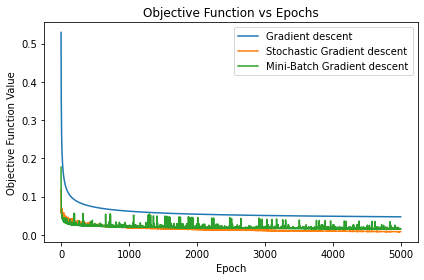

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs_gd = range(len(objval1_gd))
epochs_sgd = range(len(objval1_sgd))
epochs_mbgd = range(len(objval1_mbgd))

l1, = plt.plot(epochs_gd, objval1_gd)
l2, = plt.plot(epochs_sgd, objval1_sgd)
l3, = plt.plot(epochs_mbgd, objval1_mbgd)
plt.title("Objective Function vs Epochs")
plt.xlabel('Epoch')
plt.ylabel('Objective Function Value')
plt.legend([l1, l2, l3], ['Gradient descent', 'Stochastic Gradient descent', 'Mini-Batch Gradient descent'])
plt.tight_layout()

plt.show()

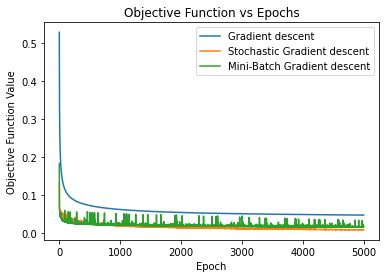

In [20]:
epochs_gd_reg = range(len(objval1_gd_r))
epochs_sgd_reg = range(len(objval1_sgd_r))
epochs_mbgd_reg = range(len(objval1_mbgd_r))

l1, = plt.plot(epochs_gd_reg, objval1_gd_r)
l2, = plt.plot(epochs_sgd_reg, objval1_sgd_r)
l3, = plt.plot(epochs_mbgd_reg, objval1_mbgd_r)
plt.title("Objective Function vs Epochs")
plt.xlabel('Epoch')
plt.ylabel('Objective Function Value')
plt.legend([l1, l2, l3], ['Gradient descent', 'Stochastic Gradient descent', 'Mini-Batch Gradient descent'])

plt.show()

# 5. Prediction
### Compare the training and testing accuracy for logistic regression and regularized logistic regression.

In [21]:
# Predict class label
# Inputs:
#     w: weights: d-by-1 matrix
#     X: data: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    prediction = (np.dot(X, w))
    f = np.array([1 if i > 0 else -1 for i in prediction])
    return f

In [22]:
# evaluate training error of logistric regression and regularized version
y_train_pred = predict(w_gd,x_train)
train_accuracy_gd = accuracy_score(y_train, y_train_pred)
print("Training accuracy for Gradient descent model: " + str(train_accuracy_gd))

y_train_pred = predict(w_sgd,x_train)
train_accuracy_sgd = accuracy_score(y_train, y_train_pred)
print("Training accuracy for Stochastic Gradient descent model: " + str(train_accuracy_sgd))

y_train_pred = predict(w_mbgd,x_train)
train_accuracy_mbgd = accuracy_score(y_train, y_train_pred)
print("Training accuracy for Mini-Batch Gradient descent model: " + str(train_accuracy_mbgd))

Training accuracy for Gradient descent model: 0.9868131868131869
Training accuracy for Stochastic Gradient descent model: 1.0
Training accuracy for Mini-Batch Gradient descent model: 0.989010989010989


In [23]:
# evaluate testing error of logistric regression and regularized version
y_test_pred = predict(w_gd,x_test)
test_accuracy_gd = accuracy_score(y_test, y_test_pred)
print("Training accuracy for Gradient descent model: " + str(test_accuracy_gd))

y_test_pred = predict(w_sgd,x_test)
test_accuracy_sgd = accuracy_score(y_test, y_test_pred)
print("Training accuracy for Stochastic Gradient descent model: " + str(test_accuracy_sgd))

y_test_pred = predict(w_mbgd,x_test)
test_accuracy_mbgd = accuracy_score(y_test, y_test_pred)
print("Training accuracy for Mini-Batch Gradient descent model: " + str(test_accuracy_mbgd))

Training accuracy for Gradient descent model: 0.9824561403508771
Training accuracy for Stochastic Gradient descent model: 0.9210526315789473
Training accuracy for Mini-Batch Gradient descent model: 0.9649122807017544
